In [1]:
import torch
import os
import mlflow
import numpy as np
import matplotlib as mpl
from ultralytics import YOLO
import ultralytics
import pycocotools.coco
import pycocowriter.coco2yolo
import requests
import sys
from hierarchical_yolo.hierarchical_detection import *
from hierarchical_yolo.fathomnet_model import *
import hierarchical_yolo.utils
import itertools
from hierarchical_yolo.viz_utils import *
from hierarchical_yolo.worms_utils import *
from hierarchical_yolo.coco_utils import *

In [2]:
RETRAIN = True

In [3]:
example_WORMS_id = get_WORMS_id('Abyssocucumis abyssorum')
example_WORMS_id

124597

In [4]:
get_WORMS_name(example_WORMS_id)

'Abyssocucumis abyssorum'

In [5]:
tree = get_WORMS_tree(example_WORMS_id)
tree

{'AphiaID': 1,
 'rank': 'Superdomain',
 'scientificname': 'Biota',
 'child': {'AphiaID': 2,
  'rank': 'Kingdom',
  'scientificname': 'Animalia',
  'child': {'AphiaID': 1806,
   'rank': 'Phylum',
   'scientificname': 'Echinodermata',
   'child': {'AphiaID': 148744,
    'rank': 'Subphylum',
    'scientificname': 'Echinozoa',
    'child': {'AphiaID': 123083,
     'rank': 'Class',
     'scientificname': 'Holothuroidea',
     'child': {'AphiaID': 1393249,
      'rank': 'Subclass',
      'scientificname': 'Actinopoda',
      'child': {'AphiaID': 123111,
       'rank': 'Order',
       'scientificname': 'Dendrochirotida',
       'child': {'AphiaID': 123187,
        'rank': 'Family',
        'scientificname': 'Cucumariidae',
        'child': {'AphiaID': 123475,
         'rank': 'Genus',
         'scientificname': 'Abyssocucumis',
         'child': {'AphiaID': 124597,
          'rank': 'Species',
          'scientificname': 'Abyssocucumis abyssorum',
          'child': None}}}}}}}}}}

In [6]:
ids = list(map(get_WORMS_id, ['Abyssocucumis abyssorum', 'Acanthascinae', 'Cucumariidae']))
trees = map(get_WORMS_tree, ids)
worms_tree = WORMS_tree_to_childparent_tree(trees)
worms_tree

{2: 1,
 1806: 2,
 148744: 1806,
 123083: 148744,
 1393249: 123083,
 123111: 1393249,
 123187: 123111,
 123475: 123187,
 124597: 123475,
 558: 2,
 22612: 558,
 131590: 22612,
 171834: 131590,
 131694: 171834,
 723592: 131694}

In [7]:
devices = list(range(torch.cuda.device_count()))
for i in devices:
    print(torch.cuda.get_device_properties(i).name)

NVIDIA GeForce GTX 1080 Ti
NVIDIA GeForce GTX 1080 Ti
NVIDIA GeForce GTX 1080 Ti
NVIDIA GeForce GTX 1080 Ti
NVIDIA GeForce GTX 1080 Ti
NVIDIA GeForce GTX 1080 Ti
NVIDIA GeForce GTX 1080 Ti


## Data

- Get the data [here](https://www.kaggle.com/competitions/fathomnet-2025/data).  
- Make a new directory in `hierarchical_yolo/data` called `fathomenet`.  
- Put the downloaded zip file into the `hierarchical_yolo/data/fathomnet`
- `unzip` said zip file directly into that folder
- make a new directory `hierarchical_yolo/data/fathomnet/test`
- move the `dataset_test.json` file into that directory

In [8]:
DATA = '../data'
DOWNLOAD_PATH = os.path.join(DATA, 'fathomnet')
COCO_PATH = os.path.join(DOWNLOAD_PATH, 'dataset_train.json')
TRAINING_PATH = os.path.join(DOWNLOAD_PATH, 'train')
HIERARCHY_COCO_PATH = os.path.join(TRAINING_PATH, 'dataset_train.json')
YOLO_PATH = os.path.join(TRAINING_PATH, 'yolo_training_data')
IMAGES_PATH = os.path.join(YOLO_PATH, 'dataset_train', 'images')
os.makedirs(YOLO_PATH, exist_ok=True)
os.makedirs(DOWNLOAD_PATH, exist_ok=True)

In [9]:
coco = pycocotools.coco.COCO(COCO_PATH)

loading annotations into memory...
Done (t=0.17s)
creating index...
index created!


<module 'matplotlib.pyplot' from '/home/noaa_brown/hierarchical_yolo/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

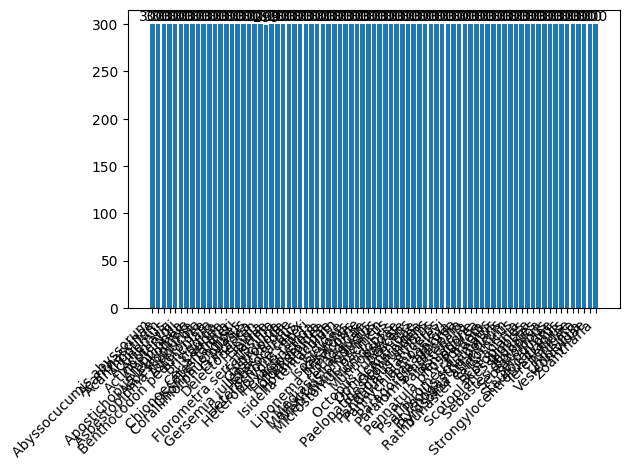

In [10]:
coco_category_dist(coco)

In [11]:
hierarchy_coco = pycocotools.coco.COCO(HIERARCHY_COCO_PATH)

loading annotations into memory...
Done (t=0.11s)
creating index...
index created!


In [12]:
hierarchy_category_id_map = {cat['name']: cat['id'] for cat in hierarchy_coco.cats.values()}
hierarchy_category_name_map = {hierarchy_category_id_map[name]: name for name in hierarchy_category_id_map}
hierarchy_category_id_map

{'Abyssocucumis abyssorum': 1,
 'Acanthascinae': 2,
 'Acanthoptilum': 3,
 'Actinernus': 4,
 'Actiniaria': 5,
 'Actinopterygii': 6,
 'Amphipoda': 7,
 'Apostichopus leukothele': 8,
 'Asbestopluma': 9,
 'Asbestopluma monticola': 10,
 'Asteroidea': 11,
 'Benthocodon pedunculata': 12,
 'Brisingida': 13,
 'Caridea': 14,
 'Ceriantharia': 15,
 'Chionoecetes tanneri': 16,
 'Chorilia longipes': 17,
 'Corallimorphus pilatus': 18,
 'Crinoidea': 19,
 'Delectopecten': 20,
 'Elpidia': 21,
 'Farrea': 22,
 'Florometra serratissima': 23,
 'Funiculina': 24,
 'Gastropoda': 25,
 'Gersemia juliepackardae': 26,
 'Heterocarpus': 27,
 'Heterochone calyx': 28,
 'Heteropolypus ritteri': 29,
 'Hexactinellida': 30,
 'Hippasteria': 31,
 'Holothuroidea': 32,
 'Hormathiidae': 33,
 'Isidella tentaculum': 34,
 'Isididae': 35,
 'Isosicyonis': 36,
 'Keratoisis': 37,
 'Liponema brevicorne': 38,
 'Lithodidae': 39,
 'Mediaster aequalis': 40,
 'Merluccius productus': 41,
 'Metridium farcimen': 42,
 'Microstomus pacificus': 4

In [13]:
yolo_category_id_map = {name: hierarchy_category_id_map[name] - 1 for name in hierarchy_category_id_map}
yolo_category_name_map = {yolo_category_id_map[name]: name for name in yolo_category_id_map}
yolo_category_id_map

{'Abyssocucumis abyssorum': 0,
 'Acanthascinae': 1,
 'Acanthoptilum': 2,
 'Actinernus': 3,
 'Actiniaria': 4,
 'Actinopterygii': 5,
 'Amphipoda': 6,
 'Apostichopus leukothele': 7,
 'Asbestopluma': 8,
 'Asbestopluma monticola': 9,
 'Asteroidea': 10,
 'Benthocodon pedunculata': 11,
 'Brisingida': 12,
 'Caridea': 13,
 'Ceriantharia': 14,
 'Chionoecetes tanneri': 15,
 'Chorilia longipes': 16,
 'Corallimorphus pilatus': 17,
 'Crinoidea': 18,
 'Delectopecten': 19,
 'Elpidia': 20,
 'Farrea': 21,
 'Florometra serratissima': 22,
 'Funiculina': 23,
 'Gastropoda': 24,
 'Gersemia juliepackardae': 25,
 'Heterocarpus': 26,
 'Heterochone calyx': 27,
 'Heteropolypus ritteri': 28,
 'Hexactinellida': 29,
 'Hippasteria': 30,
 'Holothuroidea': 31,
 'Hormathiidae': 32,
 'Isidella tentaculum': 33,
 'Isididae': 34,
 'Isosicyonis': 35,
 'Keratoisis': 36,
 'Liponema brevicorne': 37,
 'Lithodidae': 38,
 'Mediaster aequalis': 39,
 'Merluccius productus': 40,
 'Metridium farcimen': 41,
 'Microstomus pacificus': 42

In [14]:
len(hierarchy_coco.cats)

271

In [15]:
hierarchy_coco.info()

year: 2025
version: 0
description: Generated by FathomNet
contributor: FathomNet
url: https://database.fathomnet.org
date_created: 2025/01/08


In [16]:
np.unique(list(map(lambda ann: ann['category_id'], coco.anns.values())))

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78,
       79])

In [17]:
# TODO: the yolov8.yaml model file downloaded from Ultralytics needs manual editing for the number of classes
YOLO_YAML = os.path.join(DATA, 'yolov8.yaml')
YOLO_BASE_MODEL = os.path.join(DATA, 'yolov8n.pt')
YOLO_TRAIN_YAML = os.path.join(YOLO_PATH, 'train.yaml')

In [18]:
mlflow.autolog()

In [19]:
model = YOLO(YOLO_YAML).load(YOLO_BASE_MODEL)  # build a new model from scratch

WARNING ⚠️ no model scale passed. Assuming scale='n'.
Transferred 319/355 items from pretrained weights


In [20]:
#TODO we need to get the hierarchy to train this!s

In [21]:
BATCH_FACTOR = 5 # tweak this to maximize GPU usage

In [22]:
if RETRAIN:
    results = model.train(
        data=YOLO_TRAIN_YAML, 
        epochs=5, imgsz=640, 
        device=devices, 
        batch=BATCH_FACTOR*max(len(devices), 1),
        trainer=FathomnetHierarchicalDetectionTrainer,
        val=False,
        save=True,
        save_period=3
    )

New https://pypi.org/project/ultralytics/8.3.189 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.119 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:1 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:2 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:3 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:4 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:5 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:6 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
engine/trainer: task=detect, mode=train, model=../data/yolov8.yaml, data=../data/fathomnet/train/yolo_training_data/train.yaml, epochs=5, time=None, patience=100, batch=35, imgsz=640, save=Tru

train: Scanning /home/noaa_brown/hierarchical_yolo/data/fathomnet/train/yolo_training_data/dataset_train/labels.cache... 8980 images, 1 backgrounds, 5 corrupt: 100%|██████████| 8981/8981 [00:00<?, ?it/s]


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1172.7±146.5 MB/s, size: 3122.2 KB)
train: /home/noaa_brown/hierarchical_yolo/data/fathomnet/train/yolo_training_data/dataset_train/images/48806fd4-1b1c-440e-9eec-88d870a9be8a.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.00444]
train: /home/noaa_brown/hierarchical_yolo/data/fathomnet/train/yolo_training_data/dataset_train/images/71af176f-af7e-4314-b9c4-4927785a3869.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.00469]
train: /home/noaa_brown/hierarchical_yolo/data/fathomnet/train/yolo_training_data/dataset_train/images/76523c8e-4a04-4ff6-9590-e5060db4bb69.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.02315]
train: /home/noaa_brown/hierarchical_yolo/data/fathomnet/train/yolo_training_data/dataset_train/images/95065656-53c4-4474-b7ec-a8104b0f62b2.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.04459

val: Scanning /home/noaa_brown/hierarchical_yolo/data/fathomnet/train/yolo_training_data/dataset_train/labels.cache... 8980 images, 1 backgrounds, 5 corrupt: 100%|██████████| 8981/8981 [00:00<?, ?it/s]


Plotting labels to /home/noaa_brown/hierarchical_yolo/runs/detect/train129/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=3.6e-05, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.000546875), 63 bias(decay=0.0)
MLflow: logging run_id(25122c8c06e04ff5b5bf7b63446175f4) to /home/noaa_brown/hierarchical_yolo/runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri /home/noaa_brown/hierarchical_yolo/runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 14 dataloader workers
Logging results to /home/noaa_brown/hierarchical_yolo/runs/detect/train129
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      1.02G      1.814      58.05      1.352         22        640: 100%|██████████| 257/257 [01:33<00:00,  2.76it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      1.05G       1.71      48.79      1.264         22        640: 100%|██████████| 257/257 [01:30<00:00,  2.84it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      1.07G      1.677      43.58      1.243          9        640: 100%|██████████| 257/257 [01:27<00:00,  2.93it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      1.07G      1.756      39.52      1.288         25        640: 100%|██████████| 257/257 [01:27<00:00,  2.93it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      1.07G      1.763      35.98      1.289         12        640: 100%|██████████| 257/257 [01:28<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 898/898 [11:31<00:00,  1.30it/s]


                   all       8976      23662      0.112      0.122    0.00863    0.00577

5 epochs completed in 0.318 hours.
Optimizer stripped from /home/noaa_brown/hierarchical_yolo/runs/detect/train129/weights/last.pt, 7.0MB
Optimizer stripped from /home/noaa_brown/hierarchical_yolo/runs/detect/train129/weights/best.pt, 7.0MB

Validating /home/noaa_brown/hierarchical_yolo/runs/detect/train129/weights/best.pt...
Ultralytics 8.3.119 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:1 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:2 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:3 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:4 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:5 (NVIDIA GeForce 

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 898/898 [08:59<00:00,  1.66it/s]


                   all       8976      23662      0.112      0.122    0.00852    0.00566
Abyssocucumis abyssorum        267        300     0.0378       0.52     0.0419     0.0233
         Acanthascinae        211        300          0          0          0          0
         Acanthoptilum        141        300     0.0982       0.14     0.0537     0.0317
            Actinernus        104        300    0.00166     0.0433    0.00107    0.00057
            Actiniaria        159        300    0.00667      0.167    0.00349    0.00201
        Actinopterygii        264        300    0.00283      0.283    0.00205    0.00113
             Amphipoda        104        300          1          0          0          0
Apostichopus leukothele        220        300     0.0126      0.157    0.00864    0.00645
          Asbestopluma        129        300   0.000394       0.02   0.000322    0.00016
Asbestopluma monticola        100        300    0.00232    0.00333   0.000669    0.00049
            Asteroi

In [23]:
random_img = os.path.join(IMAGES_PATH, str(np.random.choice(os.listdir(IMAGES_PATH))))
random_img

'../data/fathomnet/train/yolo_training_data/dataset_train/images/22debb2f-b631-4809-bc24-a0ad39407ee4.png'

In [24]:
MODEL_LOCATION = os.path.join('..','runs','detect')
trained_models = os.listdir(os.path.join('..','runs','detect'))
model_numbers = map(lambda x: int(x[len('train'):]) if len(x) > len('train') else 0, trained_models)
latest_model = 'train' + str(max(model_numbers))

In [25]:
MODEL_WEIGHTS_PATH = os.path.join(MODEL_LOCATION, latest_model, 'weights')

In [26]:
desired_epoch = None
if desired_epoch:
    weights_file = f'epoch{desired_epoch}.pt'
else:
    weights_file = 'best.pt'
checkpoint_path = os.path.join(MODEL_WEIGHTS_PATH, weights_file)
trained_model = YOLO(
    YOLO_YAML
).load(os.path.join(MODEL_LOCATION, latest_model, 'weights', 'best.pt')).to('cuda')
trained_model.eval()

WARNING ⚠️ no model scale passed. Assuming scale='n'.
Transferred 355/355 items from pretrained weights


YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

In [27]:
predictions = trained_model.predict(random_img, verbose=False, device=devices[:1], stream=True)
prediction = next(predictions)
prediction.boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([124., 138., 124., 124., 138., 124., 124., 124., 124., 124., 138., 124., 124., 138., 138.], device='cuda:0')
conf: tensor([1.0000, 1.0000, 0.9988, 0.9957, 0.9944, 0.9765, 0.9634, 0.9014, 0.7306, 0.6899, 0.6789, 0.5372, 0.3701, 0.3515, 0.3420], device='cuda:0')
data: tensor([[5.8340e+01, 4.3687e+02, 1.6412e+02, 5.6467e+02, 1.0000e+00, 1.2400e+02],
        [8.7250e+02, 3.2493e+02, 1.2293e+03, 8.0074e+02, 9.9996e-01, 1.3800e+02],
        [1.0028e+03, 8.4080e+02, 1.1037e+03, 9.7665e+02, 9.9884e-01, 1.2400e+02],
        [1.0391e+02, 8.3374e+02, 1.5266e+02, 8.7751e+02, 9.9568e-01, 1.2400e+02],
        [5.2423e+01, 4.3767e+02, 1.6669e+02, 5.5679e+02, 9.9436e-01, 1.3800e+02],
        [1.0779e+03, 2.3861e+00, 1.1451e+03, 7.7283e+01, 9.7650e-01, 1.2400e+02],
        [7.3380e+02, 7.5763e+02, 8.2115e+02, 8.6357e+02, 9.6343e-01, 1.2400e+02],
        [8.6155e+02, 8.4196e+02, 9.2345e+02, 9.0273e+02, 9.0137e-01, 1.2400e+02],
       

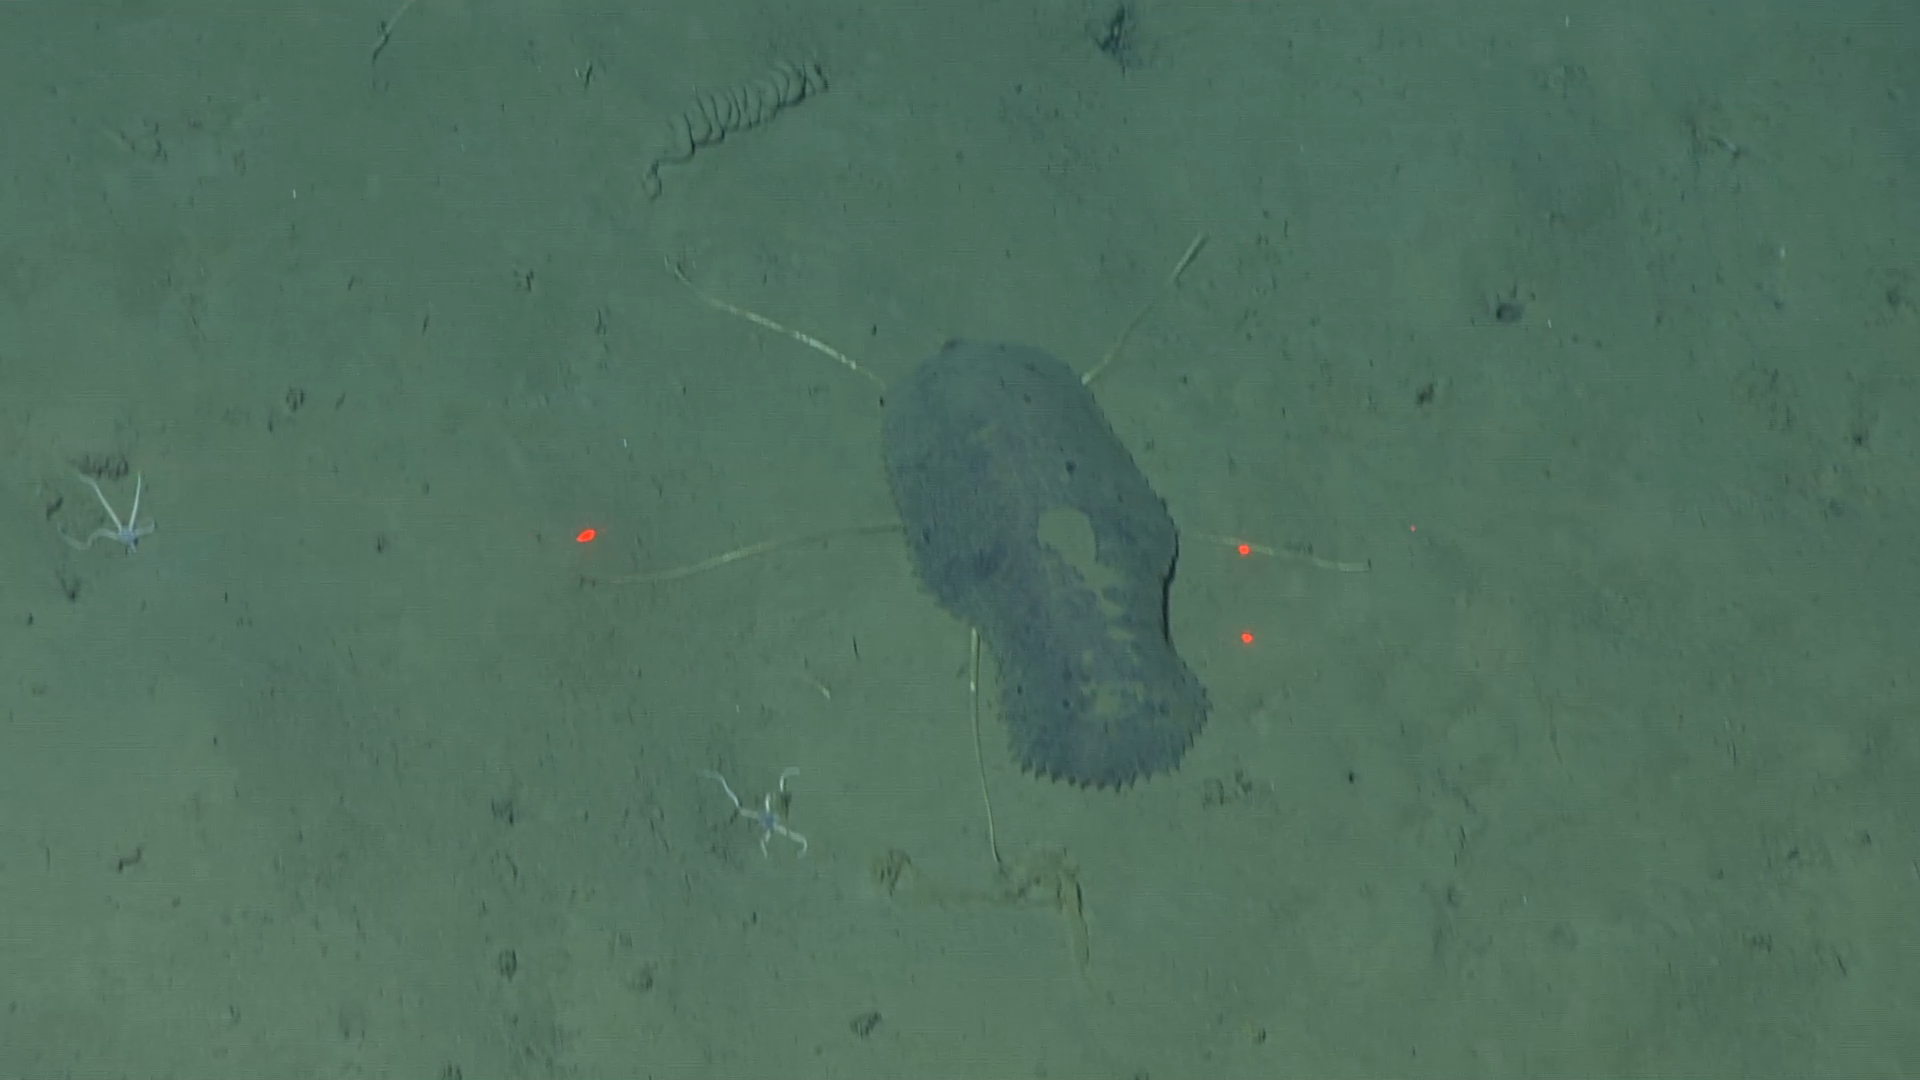

In [28]:
import torch
from PIL import Image

# Load and preprocess
image = Image.open(random_img).convert('RGB')
image

In [29]:
import importlib
importlib.reload(hierarchical_yolo.utils)

<module 'hierarchical_yolo.utils' from '/home/noaa_brown/hierarchical_yolo/hierarchical_yolo/utils.py'>

In [30]:
predicted_boxes, predicted_paths, predicted_path_scores = hierarchical_yolo.utils.hierarchical_predict(trained_model, FathomnetHierarchicalDetectionTrainer._hierarchy, [image, image], cuda=True)

In [31]:
predicted_paths[0][0]

[124, 138, 181, 193, 118, 133, 217, 173, 108, 28]

In [32]:
list(map(lambda i: yolo_category_name_map[i], predicted_paths[0][0]))

['Biota',
 'Animalia',
 'Cnidaria',
 'Anthozoa',
 'Octocorallia',
 'Scleralcyonacea',
 'Coralliidae',
 'Anthomastinae',
 'Heteropolypus',
 'Heteropolypus ritteri']

In [33]:
FathomnetHierarchicalDetectionTrainer._hierarchy[39]

84

In [34]:
predicted_path_scores[0][0]

tensor([9.9992e-01, 9.5668e-01, 9.7478e-01, 8.5738e-01, 8.4632e-02, 6.8749e-04, 1.0384e-01, 1.0666e-06, 1.0114e-01, 4.1440e-03], device='cuda:0')

In [35]:
trunc_path, trunc_score = truncate_path(predicted_paths[0][0], predicted_path_scores[0][0])
print(list(map(lambda i: yolo_category_name_map[i], trunc_path)))
trunc_score

['Biota', 'Animalia', 'Cnidaria', 'Anthozoa']


tensor([0.9999, 0.9567, 0.9748, 0.8574], device='cuda:0')

In [36]:
for paths, scores in zip(predicted_paths[0], predicted_path_scores[0]):
    tpath, tscore = truncate_path(paths, scores)
    print(list(map(lambda i: yolo_category_name_map[i], tpath)))
    print(tscore)

['Biota', 'Animalia', 'Cnidaria', 'Anthozoa']
tensor([0.9999, 0.9567, 0.9748, 0.8574], device='cuda:0')
['Biota', 'Animalia', 'Cnidaria', 'Anthozoa']
tensor([0.9998, 0.8618, 0.9279, 0.5500], device='cuda:0')
['Biota', 'Animalia', 'Cnidaria', 'Anthozoa']
tensor([0.9984, 0.7723, 0.7133, 0.6849], device='cuda:0')
['Biota', 'Animalia', 'Cnidaria']
tensor([0.9951, 0.7806, 0.5779], device='cuda:0')
['Biota', 'Animalia', 'Cnidaria']
tensor([0.9928, 0.5483, 0.5347], device='cuda:0')
['Biota']
tensor([0.9923], device='cuda:0')
['Biota', 'Animalia']
tensor([0.9813, 0.4064], device='cuda:0')
['Biota']
tensor([0.4635], device='cuda:0')
['Biota']
tensor([0.4108], device='cuda:0')
['Biota']
tensor([0.4097], device='cuda:0')


In [37]:
import functools

In [38]:
tpaths, tscores = [], []
for paths, scores in zip(predicted_paths[0], predicted_path_scores[0]):
    tpath, tscore = truncate_path(paths, scores, threshold=0.3)
    tpaths.append(tpath), tscores.append(tscore)

In [39]:
tpaths

[[124, 138, 181, 193],
 [124, 138, 181, 193],
 [124, 138, 181, 193],
 [124, 138, 181],
 [124, 138, 181],
 [124],
 [124, 138],
 [124],
 [124],
 [124]]

In [40]:
bpath, bscore = [p[-1] if p else 124 for p in tpaths], [functools.reduce(lambda x,y: x*y, s, 1) for s in tscores]

(640, 640) (1080, 1920)
3.0 1.6875
(640, 640) (1080, 1920)
3.0 1.6875
(640, 640) (1080, 1920)
3.0 1.6875
(640, 640) (1080, 1920)
3.0 1.6875
(640, 640) (1080, 1920)
3.0 1.6875
(640, 640) (1080, 1920)
3.0 1.6875
(640, 640) (1080, 1920)
3.0 1.6875
(640, 640) (1080, 1920)
3.0 1.6875
(640, 640) (1080, 1920)
3.0 1.6875
(640, 640) (1080, 1920)
3.0 1.6875


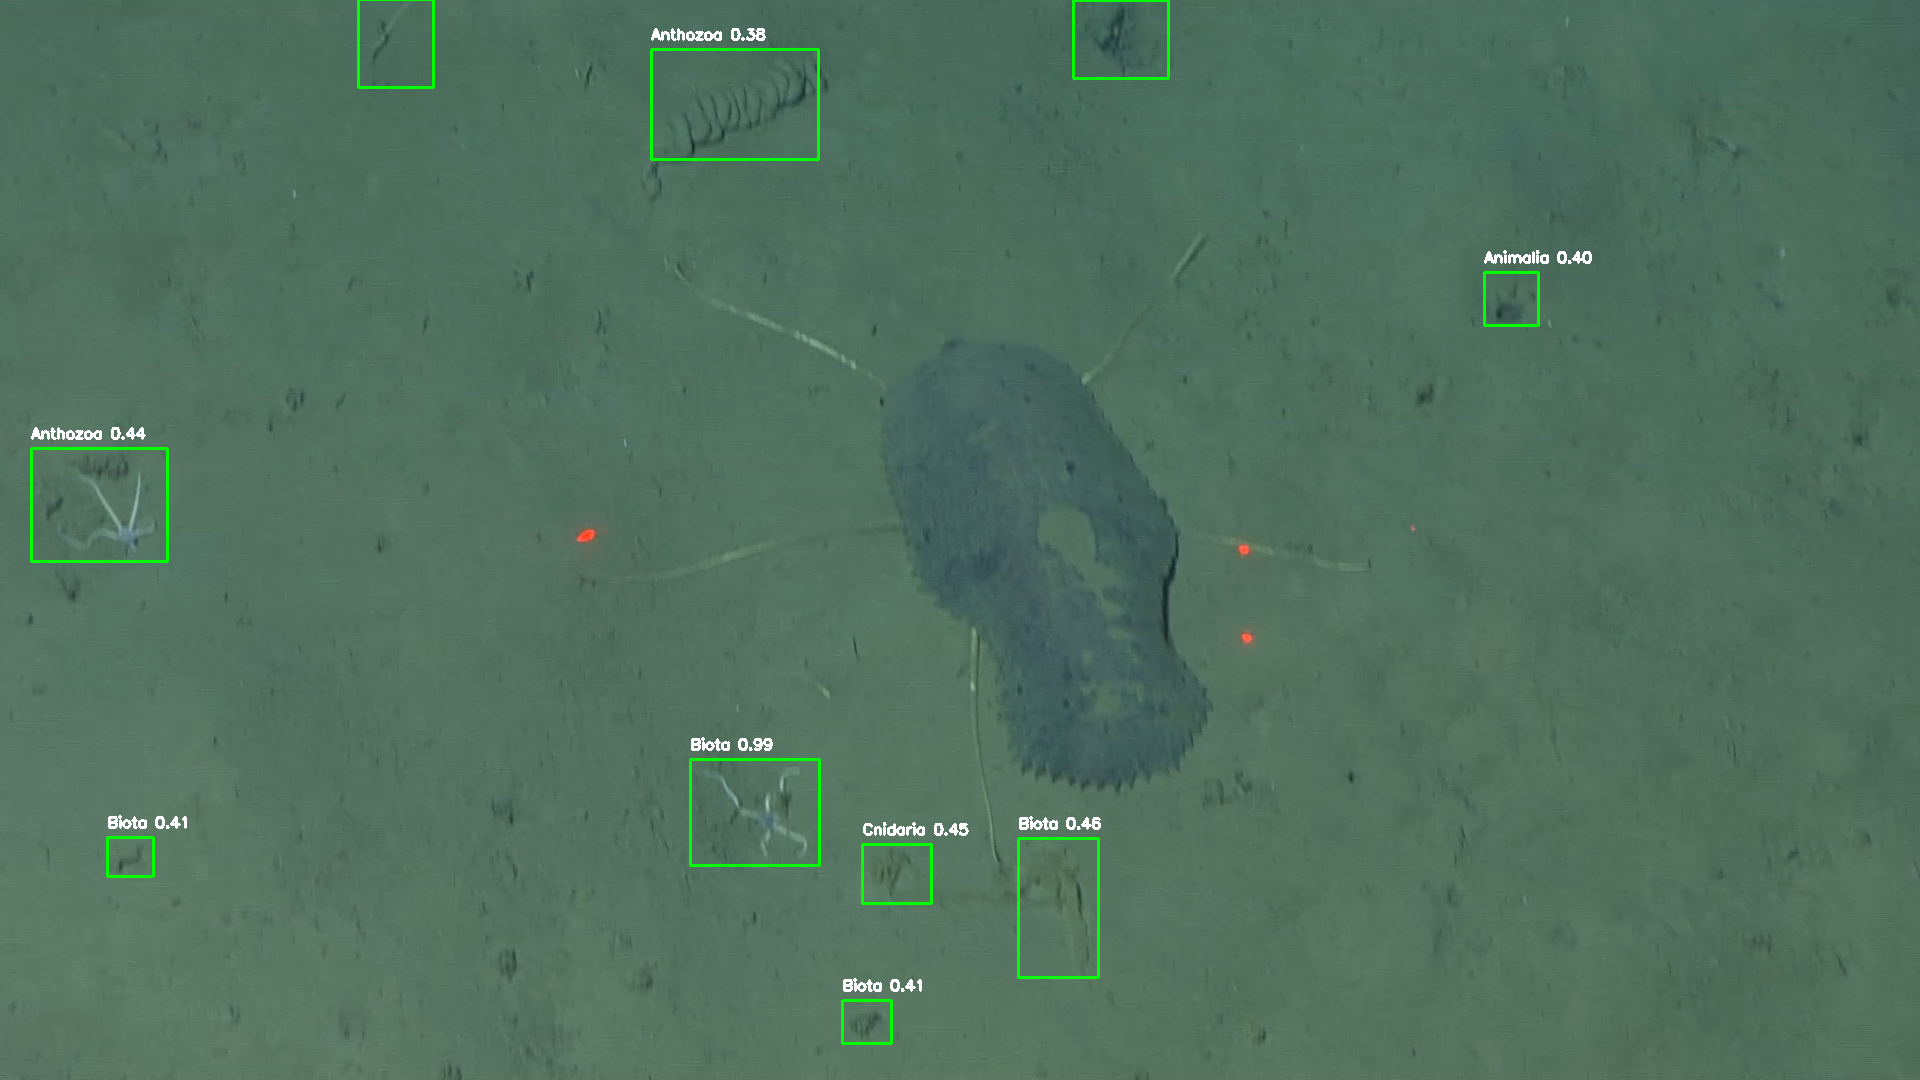

In [41]:
draw_boxes_on_image(image, predicted_boxes[0].T, 
                    labels=[yolo_category_name_map[p] for p in bpath], 
                    scores=bscore, box_color=(0, 255, 0), text_color=(255, 255, 255))

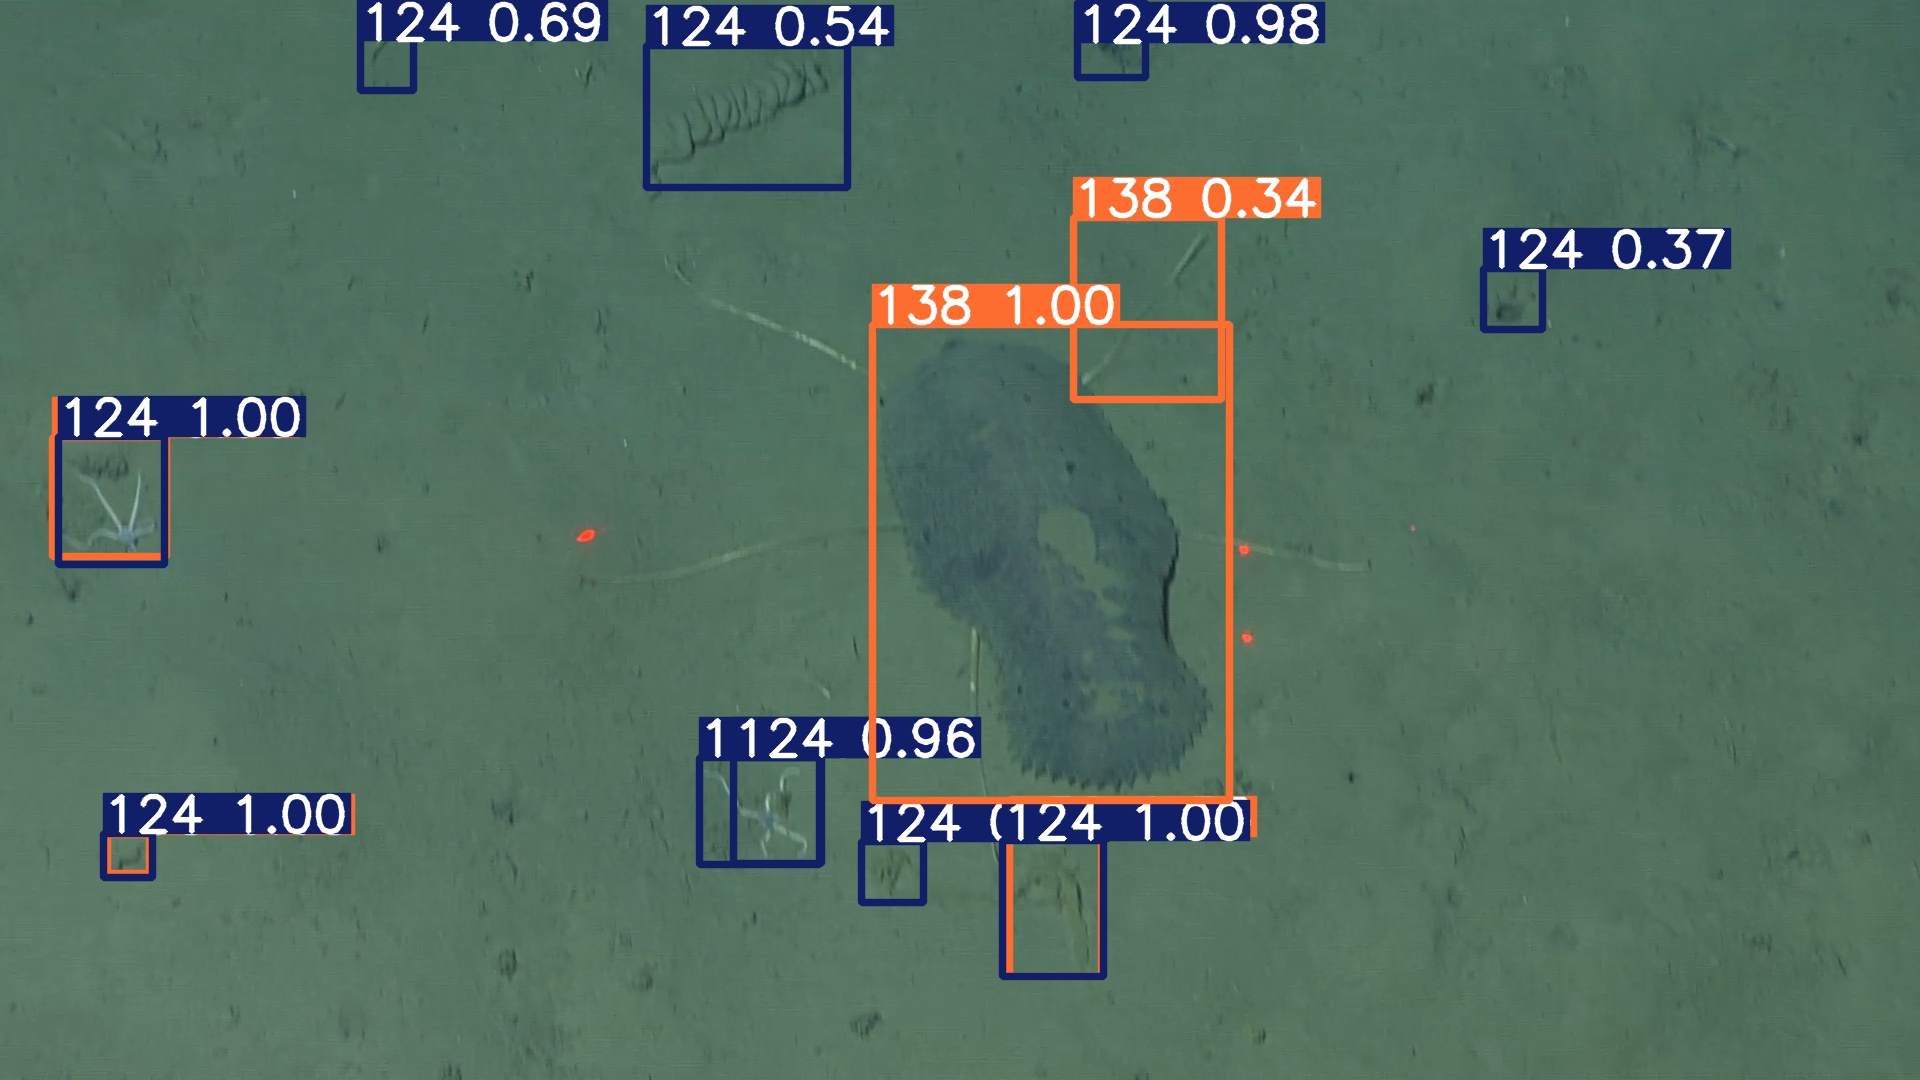

In [42]:
prediction.save('pickles.jpg')
from IPython.display import Image as IPy_Image
IPy_Image(filename='pickles.jpg') 

In [ ]:
TEST_PATH = os.path.join(DOWNLOAD_PATH, 'test')
TEST_COCO_PATH = os.path.join(TEST_PATH, 'dataset_test.json')
TEST_IMAGES_PATH = os.path.join(TEST_PATH, 'images')
os.makedirs(TEST_IMAGES_PATH, exist_ok=True)

In [ ]:
test_coco = pycocotools.coco.COCO(TEST_COCO_PATH)

In [ ]:
test_coco.download(TEST_IMAGES_PATH)

In [ ]:
test_images = list(map(lambda im: os.path.join(TEST_IMAGES_PATH, im), os.listdir(TEST_IMAGES_PATH)))

In [ ]:
loaded_images = list(map(lambda im: Image.open(im).convert('RGB'), test_images))

In [ ]:
predicted_boxes, predicted_paths, predicted_path_scores = [], [], []

i=0
for batch in itertools.batched(loaded_images, n=25):
    i+=1
    print(i)
    pb, pp, pps = hierarchical_yolo.utils.hierarchical_predict(trained_model, FathomnetHierarchicalDetectionTrainer._hierarchy, batch, cuda=True)
    predicted_boxes += pb
    predicted_paths += pp
    predicted_path_scores += pps

In [ ]:
predicted_boxes[0][:,0]

In [ ]:
predicted_boxes[0][:,2]

In [ ]:
predicted_boxes[0].min()

In [ ]:
i = int(np.random.uniform(1, len(loaded_images)))
i

In [ ]:
import functools

In [ ]:
tpaths, tscores = [], []
for paths, scores in zip(predicted_paths[i], predicted_path_scores[i]):
    tpath, tscore = truncate_path(paths, scores)
    tpaths.append(tpath), tscores.append(tscore)

In [ ]:
bpath, bscore = [p[-1] for p in tpaths], [functools.reduce(lambda x,y: x*y, s, 1) for s in tscores]

In [ ]:
loaded_images[i].size

In [ ]:
rescale_boxes(predicted_boxes[i].T.clone(), (640,640), loaded_images[i].size[::-1])

In [ ]:
predicted_boxes[i].T

In [ ]:
draw_boxes_on_image(loaded_images[i], predicted_boxes[i].T, 
                    labels=[yolo_category_name_map[p] for p in bpath], 
                    scores=bscore, box_color=(0, 255, 0), text_color=(255, 255, 255))